# Using a Modflow DRN model as a stressmodel in Pastas

In [1]:
import os

import flopy
import pandas as pd
import pastas as ps

import pastas_plugins.modflow as ppmf

bindir = "bin"
mf6_exe = os.path.join(bindir, "mf6.exe")
if not os.path.isfile(mf6_exe):
    if not os.path.isdir(bindir):
        os.makedirs(bindir)
    flopy.utils.get_modflow("bin", repo="modflow6")

In [2]:
df = pd.read_csv("data/aftopping.csv", index_col=0, parse_dates=True)
head = df["B28H1808_2"].dropna()
prec = df["Precipitation"]
evap = df["Evaporation"]

## Try to model TARSO with a one cell MODFLOW model

Fit report B28H1808_2             Fit Statistics
nfev    16                     EVP         96.88
nobs    1261                   R2           0.97
noise   False                  RMSE         0.05
tmin    2012-06-07 00:00:00    AICc     -7360.14
tmax    2017-02-01 00:00:00    BIC      -7324.25
freq    D                      Obj          1.82
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (7 optimized)
           optimal     initial  vary
exp_A0  661.881263  258.226873  True
exp_a0  117.485675   10.000000  True
exp_d0   19.664685   19.675000  True
exp_A1  368.738780  258.226873  True
exp_a1  138.281724   10.000000  True
exp_d1   20.000696   20.032500  True
exp_f    -1.060276   -1.000000  True


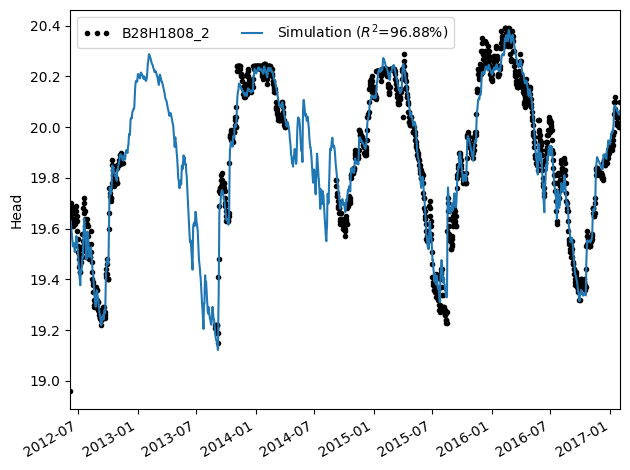

In [3]:
ml_tarso = ps.Model(head, constant=False)
ml_tarso.add_stressmodel(
    ps.TarsoModel(
        prec=prec, evap=evap, rfunc=ps.Exponential(), name="exp", oseries=head
    )
)
ml_tarso.solve()
ml_tarso.plot();

We generate a model with ModflowDrnSto, which adds a drain at a certain threshold-value, and modifies the storage coefficient above this level. If we calculate the parameter-values from the optimized Pastas model with TarsoModel, we see this model returns the same simulation.

Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.


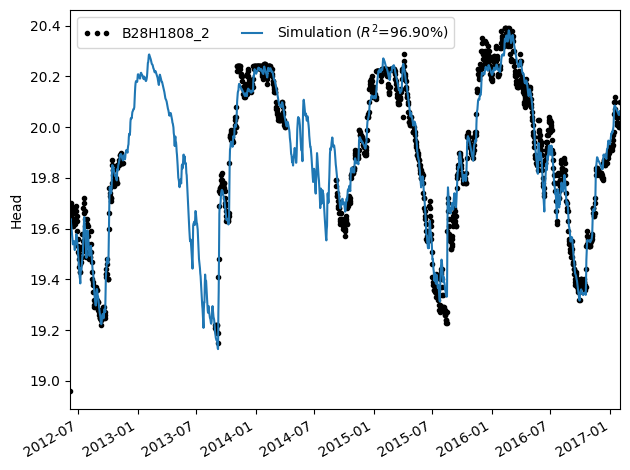

In [4]:
# Generate a Model with ModflowDrnSto
ml_mds = ps.Model(head, constant=False)
modflow = ppmf.ModflowDrnSto(
    exe_name=mf6_exe, sim_ws="mf_files/drn_gw", head=head, silent=True
)
mm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=modflow, name="modflow")
ml_mds.add_stressmodel(mm)

# take parameters from the model with the TarsoModel
p_tarso = ml_tarso.parameters["optimal"]
ml_mds.set_parameter(f"{mm.name}_d", initial=p_tarso["exp_d0"])
ml_mds.set_parameter(f"{mm.name}_c", initial=p_tarso["exp_A0"])
s = p_tarso["exp_a0"] / p_tarso["exp_A0"]
ml_mds.set_parameter(f"{mm.name}_s", initial=s)
ml_mds.set_parameter(f"{mm.name}_f", initial=p_tarso["exp_f"])
h_drn = p_tarso["exp_d1"] - p_tarso["exp_d0"]
ml_mds.set_parameter(f"{mm.name}_h_drn", initial=h_drn)
ml_mds.set_parameter(f"{mm.name}_c_drn", initial=p_tarso["exp_A1"])
s_drn = p_tarso["exp_a1"] / p_tarso["exp_A1"]
ml_mds.set_parameter(f"{mm.name}_s_drn", initial=s_drn)

# initialize model and plot
ml_mds.initialize()
ax = ml_mds.plot()

In [5]:
ml_mds.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
modflow_d,19.664685,18.960,2.039000e+01,True,modflow,uniform,NaN,NaN
modflow_c,661.881263,10.000,1.000000e+08,True,modflow,uniform,NaN,NaN
modflow_s,0.177503,0.001,5.000000e-01,True,modflow,uniform,NaN,NaN
modflow_f,-1.060276,-2.000,0.000000e+00,True,modflow,uniform,NaN,NaN
modflow_h_drn,0.336012,0.000,1.000000e+01,True,modflow,uniform,NaN,NaN
modflow_c_drn,368.738780,10.000,1.000000e+08,True,modflow,uniform,NaN,NaN
modflow_s_drn,0.375013,0.001,1.000000e+00,True,modflow,uniform,NaN,NaN


We can plot the difference between the two models. This difference is smaller than the closing criterium of the MODFLOW-model (0.01 meter).

Model is not optimized yet, initial parameters are used.


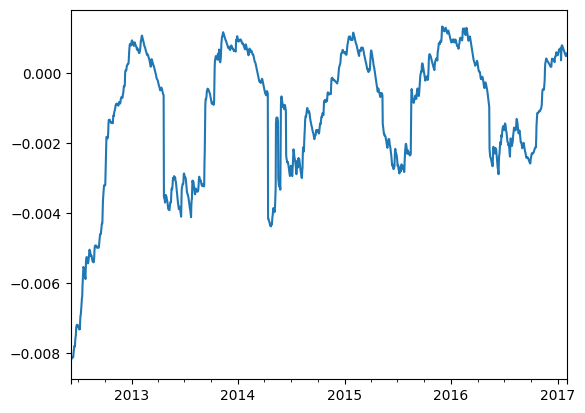

In [6]:
# plot the difference between both models
h1 = ml_tarso.simulate()
h2 = ml_mds.simulate()
(h1 - h2).dropna().plot();

## Try to model ThresholdTransform with a one cell MODFLOW model

Fit report B28H1808_2               Fit Statistics
nfev    26                     EVP           96.82
nobs    1261                   R2             0.97
noise   False                  RMSE           0.05
tmin    2012-06-07 00:00:00    AICc       -7335.76
tmax    2017-02-01 00:00:00    BIC        -7304.99
freq    D                      Obj            1.86
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                         optimal     initial  vary
recharge_A            594.799905  258.226873  True
recharge_a            103.941136   10.000000  True
recharge_f             -1.060085   -1.000000  True
constant_d             19.658142   19.880246  True
ThresholdTransform_1   20.008782   20.032500  True
ThresholdTransform_2    0.441636    0.500000  True


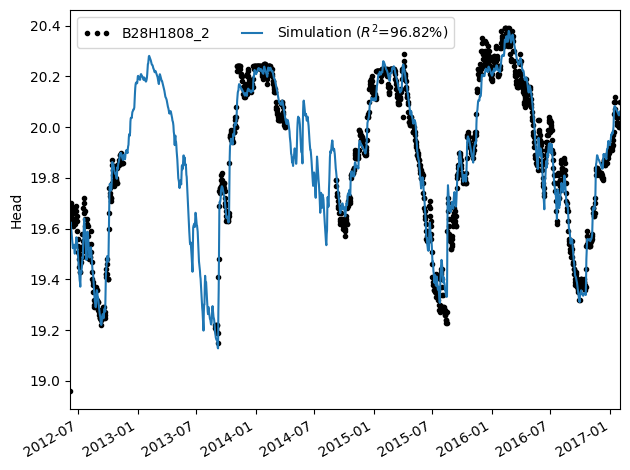

In [7]:
ml_tt = ps.Model(head)
ml_tt.add_stressmodel(ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential()))
ml_tt.add_transform(ps.ThresholdTransform())
ml_tt.solve()
ml_tt.plot();

We try to model this sytyem with ModflowSto. However, this does not give us the same simulation.

Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.


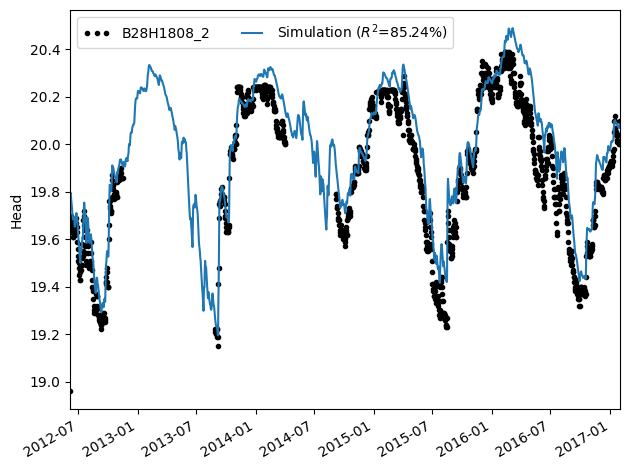

In [8]:
ml_ms = ps.Model(head, constant=False)
modflow = ppmf.ModflowSto(
    exe_name=mf6_exe, sim_ws="mf_files/drn_gw", head=head, silent=True
)
mm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=modflow, name="modflow")
ml_ms.add_stressmodel(mm)

p_tt = ml_tt.parameters["optimal"]
ml_ms.set_parameter(f"{mm.name}_d", initial=p_tt["constant_d"])
ml_ms.set_parameter(f"{mm.name}_c", initial=p_tt["recharge_A"])
s = p_tt["recharge_a"] / p_tt["recharge_A"]
ml_ms.set_parameter(f"{mm.name}_s", initial=s)
ml_ms.set_parameter(f"{mm.name}_f", initial=p_tt["recharge_f"])
h_drn = p_tt["ThresholdTransform_1"] - p_tt["constant_d"]
ml_ms.set_parameter(f"{mm.name}_h_drn", initial=h_drn)
s_drn = s / p_tt["ThresholdTransform_2"]
ml_ms.set_parameter(f"{mm.name}_s_drn", initial=s_drn)

ml_ms.initialize()
ax = ml_ms.plot()

With ModflowDrnSto we come closer, but we do not get the same result as the Pastas Model with the ThresholdTransform. It is not possible to model the ThresholdTransform in a one-cell Modflow model. ThresholdTransform calculates the discharged water using the non-transformed simulation. However, in the Modflow model, the calculation of the discharge is calculated using the simulation that is affected by the larger storage coefficient.

Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.


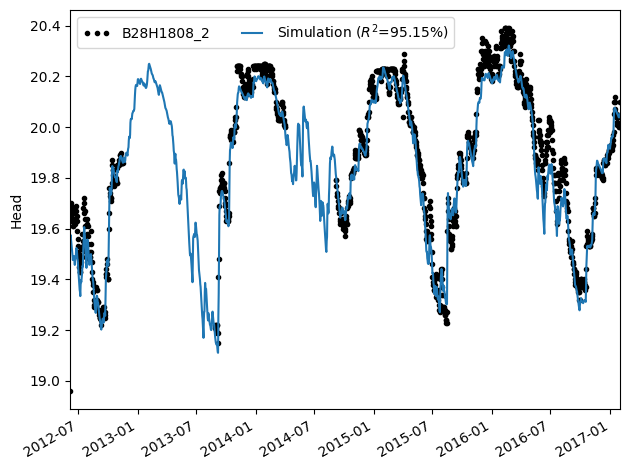

In [9]:
# Generate a Model with ModflowDrnSto
ml_mds = ps.Model(head, constant=False)
modflow = ppmf.ModflowDrnSto(
    exe_name=mf6_exe, sim_ws="mf_files/drn_gw", head=head, silent=True
)
mm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=modflow, name="modflow")
ml_mds.add_stressmodel(mm)

# take parameters from the model with the TarsoModel
p_tt = ml_tt.parameters["optimal"]
ml_mds.set_parameter(f"{mm.name}_d", initial=p_tt["constant_d"])
ml_mds.set_parameter(f"{mm.name}_c", initial=p_tt["recharge_A"])
s = p_tt["recharge_a"] / p_tt["recharge_A"]
ml_mds.set_parameter(f"{mm.name}_s", initial=s)
ml_mds.set_parameter(f"{mm.name}_f", initial=p_tt["recharge_f"])
h_drn = p_tt["ThresholdTransform_1"] - p_tt["constant_d"]
ml_mds.set_parameter(f"{mm.name}_h_drn", initial=h_drn)
c_drn = p_tt["recharge_A"] * p_tt["ThresholdTransform_2"]
ml_mds.set_parameter(f"{mm.name}_c_drn", initial=c_drn)
s_drn = s / p_tt["ThresholdTransform_2"]
ml_mds.set_parameter(f"{mm.name}_s_drn", initial=s_drn)

# initialize model and plot
ml_mds.initialize()
ax = ml_mds.plot()